# 31회 ADP 복원 

# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/mandysia/obesity-dataset-cleaned-and-data-sinthetic 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv
- 데이터 설명 : 각 환자의 의료정보이다. NObeyesdad를 종속변수로 하는 분류모델을 만드려고 한다.


    id: unique id for each row    
    Gender: sex - male or female    
    Age: age    
    Height: height    
    Weight: weight    
    family_history_with_overweight: Has a family member suffered or suffers f from overweight? - yes or no    
    FAVC: Frequent consumption of high caloric food - yes or no     
    FCVC: Frequency of consumption of vegetables - Never, Sometimes, Always    
    NCP: Number of main meals - 1, 2, 3, 4     
    CAEC: Consumption of food between meals - No, Sometimes, Frequently, Always    
    SMOKE: Do you smoke - yes o no    
    CH2O: Consumption of water daily - Less than a litter, between 1 and 2 l, more than 2 l    
    SCC: Calories consumption monitoring - yes or no   
    FAF: Physical activity frequency - 0, 1 to 2, 2 to 4, 4 to 5     
    TUE: Time using technology devices - 0 to 2, 3 to 5, >5    
    CALC: Consumption of alcohol - no, sometimes, frequently, always    
    MTRANS: Transportation used - automobile, motorbike, bike, public_transportation, walking    
    BMI: Body mass index
    
    (종속변수)     
    NObeyesdad: Type of obesity - overweight-level_i, obesity_type_i, obesity_type_ii, obesity_type_iii

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1-1  EDA & 결측치 및 이상치를 판단하고 설명하라

Age
      Gender  Age    Height  Weight family_history_with_overweight FAVC  \
2       male   41  1.800000      99                             no  yes   
5     female   52  1.690000      87                            yes  yes   
16      male   55  1.780000      84                            yes   no   
17    female   38  1.560000      80                            yes  yes   
26      male   44  1.600000      80                            yes   no   
...      ...  ...       ...     ...                            ...  ...   
926     male   37  1.762921     118                            yes  yes   
927     male   38  1.752863     119                            yes  yes   
928     male   39  1.768235     118                            yes  yes   
929     male   38  1.766888     118                            yes  yes   
1193  female  150  1.686033     105                            yes  yes   

           FCVC  NCP        CAEC SMOKE               CH2O  SCC     FAF  \
2     sometimes    3 

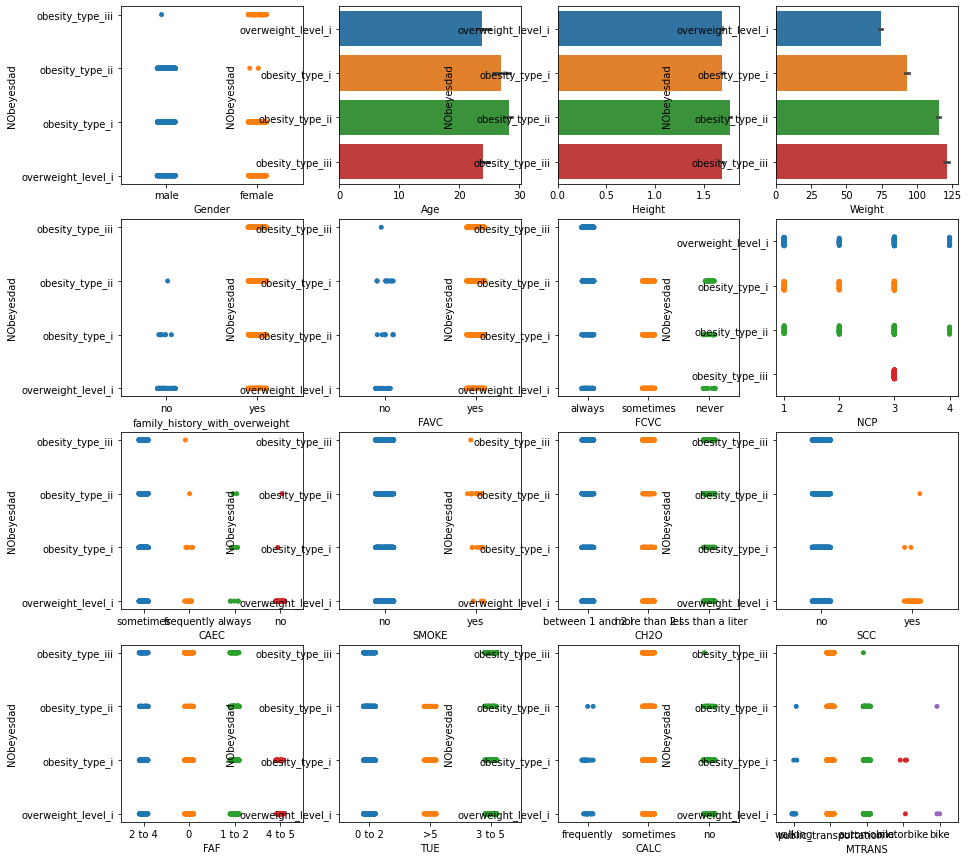

In [119]:
data = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv')
data = data.iloc[:,2:] #분석에 필요없는 칼럼 제거
data.columns.to_list()
data = data[['Gender','Age','Height','Weight','family_history_with_overweight','FAVC','FCVC','NCP','CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS', 'BMI','NObeyesdad']]

null = data.isna().sum().to_frame().T
null.index = ['결측치수']
unique = data.nunique().to_frame().T
unique.index = ['유니크수']
types = data.dtypes.to_frame().T
types.index = ['타입']
df = pd.concat([null, unique, types])


fig, axes = plt.subplots(4,4, figsize = (15,15))

for i, ax in enumerate(axes.flat[:]):
    n_col_name = data.columns[i]
    target = data[[n_col_name, 'NObeyesdad',]]
    
    if n_col_name in ['Age', 'Weight', 'Height', 'BMI']:
        sns.barplot(data = target, x = n_col_name, y = 'NObeyesdad', ax=ax)
    else:
        sns.stripplot(data = target, x = n_col_name, y = 'NObeyesdad', ax=ax)
        
        
#IQR을 이용해 이상치 판단
for j in ['Age','Height', 'Weight', 'BMI']:
    first_quantile = data['%s'%j].quantile(0.25)
    third_quantile = data['%s'%j].quantile(0.75)
    IQR = third_quantile - first_quantile
    outliers = data[(data['%s'%j]>third_quantile + 1.5*IQR) | (data['%s'%j]<first_quantile - 1.5*IQR)]
    print(j)
    print(outliers)
    
#Age칼럼에서 IQR이용시 이상치 과다검출 Age = 150인건들 때문에 과다검출된것으로 판단
outliers_age = data[data['Age'] > 100]
outliers_weight = data[data['Weight'] == 184]
outliers_to_drop = pd.concat((outliers_age, outliers_weight))

drop_outliers = data.drop(index = outliers_to_drop.index)

#SCC칼럼에 결측치 3건 존재 최빈값으로 대체
data_pre = drop_outliers.copy()
data_pre['SCC'] = data_pre.SCC.fillna(data_pre.SCC.mode())


print('분석에 상관없는 칼럼을 제거해준다.')
print('총 독립변수는 16개로 수치형 변수 4개 범주형 변수 12개이다.')
print('범주형 변수에서는 주어진 범주를 벗어난 값이 관측되지 않는다.')
print('IQR 사용시 Age 칼럼에서 이상치가 100건 넘게 관측되는데 이는 Age = 150인 이상치 들이 다량 포함되어 있어서 그런것으로 판단된다.')
print('Weight에서는 1개의 이상치가 관측되었으며 Height와 BMI에서는 이상치가 관측되지 않았다.')
print('이상치들을 제거해 주었고 SCC칼럼에서 결측치가 3건 관측되어 최빈값으로 대체해 주었다.')

## 1-2 데이터 전처리 기법 2가지를 설명하고 주어진 데이터에 적용시 어떤 효과가 있는지 설명하라

In [42]:
print('범주형 데이터들중 불균형한 칼럼이 다수 이를 완화해주기 위해 두가지 방법을 제시해본다.')
print('1)언더샘플링\n한 칼럼에서 샘플의 수가 많은 값을 수가 적은 값에 맞게 수를 줄여 샘플링한다.')
print('과적합을 줄일수 있지만 주어진 데이터 셋에서 수가 많은 값이 월등히 많아 데이터의 많은 양이 소실될것이라 예상된다.')
print('2)오버샘플링\n한 칼럼에서 샘플의 수가 적은 값을 수가 많은 값에 맞게 수를 늘려 샘플링한다.')
print('데이터의 소실없이 사용할수 있지만 과적합이 발생할 수 있다. SMOTE방식이 대표적인 예이다.')

범주형 데이터들중 불균형한 칼럼이 다수 이를 완화해주기 위해 두가지 방법을 제시해본다.
1)언더샘플링
한 칼럼에서 샘플의 수가 많은 값을 수가 적은 값에 맞게 수를 줄여 샘플링한다.
과적합을 줄일수 있지만 주어진 데이터 셋에서 수가 많은 값이 월등히 많아 데이터의 많은 양이 소실될것이라 예상된다.
2)오버샘플링
한 칼럼에서 샘플의 수가 적은 값을 수가 많은 값에 맞게 수를 늘려 샘플링한다.
데이터의 소실없이 사용할수 있지만 과적합이 발생할 수 있다. SMOTE방식이 대표적인 예이다.


## 1-3 피쳐 엔지니어링을 통해 파생변수 1개를 생성하고 그 이유를 말하라

In [120]:
data_pre['CALC'] = data_pre.CALC.apply(lambda x : 'yes' if x in ['frequently', 'sometimes'] else 'no')

print('CALC변수를 새로운 2진 변수로 변환')

CALC변수를 새로운 2진 변수로 변환


## 2-1 앙상블을 제외한 분류 모델 3가지 구축 및 결과 비교 및 설명하라

In [138]:
import warnings
warnings.filterwarnings(action='ignore')

In [164]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

x = data_pre.iloc[:,:-1]
y = data_pre.iloc[:,-1]

ordEN = OrdinalEncoder()
y = ordEN.fit_transform(y.to_frame())

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3, random_state=2024, stratify=y)

num_col = ['Age', 'Height', 'Weight', 'BMI', 'NCP']
cat_col = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']

pipeline = ColumnTransformer([('num', StandardScaler(), num_col), ('cat', OneHotEncoder(), cat_col)])
x_train_pre = pipeline.fit_transform(x_train)
x_test_pre = pipeline.transform(x_test)

model1 = LogisticRegression(random_state=2024)
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier(max_depth = 5, random_state = 38)

model1.fit(x_train_pre, y_train)
model2.fit(x_train_pre, y_train)
model3.fit(x_train_pre, y_train)

y_pred1 = model1.predict(x_test_pre)
y_pred2 = model2.predict(x_test_pre)
y_pred3 = model3.predict(x_test_pre)

print('로지스틱')
print(confusion_matrix(y_test, y_pred1))
print(f1_score(y_test, y_pred1, average = 'macro'))
print('KNN')
print(confusion_matrix(y_test, y_pred2))
print(f1_score(y_test, y_pred2, average = 'macro'))
print('의사결정나무')
print(confusion_matrix(y_test, y_pred3))
print(f1_score(y_test, y_pred3, average = 'macro'))
print('로지스틱, KNN, 의사결정나무 3가지 모델을 구축하였다.')
print('세 모델 모두 유사한 결과가 나왔고 f1 score는 의사결정나무, 로지스틱, KNN순으로 높았다.')

로지스틱
[[101   4   0   0]
 [  0  89   0   0]
 [  0   0  97   0]
 [  0   0   0  87]]
0.9896511255734557
KNN
[[97  7  0  1]
 [ 0 89  0  0]
 [ 0  0 97  0]
 [ 6  0  0 81]]
0.9633585878778187
의사결정나무
[[102   3   0   0]
 [  0  89   0   0]
 [  0   0  97   0]
 [  0   0   0  87]]
0.9922331651853631
로지스틱, KNN, 의사결정나무 3가지 모델을 구축하였다.
세 모델 모두 유사한 결과가 나왔고 f1 score는 의사결정나무, 로지스틱, KNN순으로 높았다.


## 2-2 2-1에서 사용한 모델 중 하나를 골라 그리드 서치를 통해서 파라미터 튜닝 및 분류 모델 성능 평가 (precision ,recall)

In [168]:
from sklearn.model_selection import GridSearchCV

param = {'criterion':['gini', 'entropy'], 'max_depth':[3,5,7,10], 'max_features':['auto', 'sqrt', 'log2'], 'min_samples_leaf':[1,2,3,4,5]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=38), param, cv=5)
grid.fit(x_train_pre, y_train)
grid.best_params_
best_model = grid.best_estimator_
y_pred_best = best_model.predict(x_test_pre)

precision = precision_score(y_test, y_pred_best, average = 'macro')
recall = recall_score(y_test, y_pred_best, average = 'macro')

print('f1 score가 가장높았던 의사결정나무로 하이퍼파라미터튜닝진행')
print('그 결과는 다음과 같다')
print('precision score:', precision)
print('recall score:', recall)

f1 score가 가장높았던 의사결정나무로 하이퍼파라미터튜닝진행
그 결과는 다음과 같다
precision score: 0.9536973443223443
recall score: 0.9483413590155163


## 2-3 2-1의 3가지 모델을 soft voting을 이용하여 모델링 한 결과와 2-2과 비교하라

## 3-2 하나의 모델을 선정하여 Drop Column Importance 방식으로 각 변수 별로 전체 컬럼을 포함한 모델과의 recall 값의 차이를 계산하고 시각화 하라

## 데이터 설명
- 데이터 출처 : 자체제작
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv
- 데이터 설명 : 중고등학생 건강검진 데이터

## 4-1 아래의 기준으로 전처리를 하여 적정 체중 여부 컬럼을 생성하고 BMI를 5단위로 구분하여 와 적정 체중여부에 대한 빈도 표를 만들어라
 
> bmi 계산
    - Bmi = 몸무게(kg)/(키(m)**2)   

> 만나이 구하기
    - 건강검진을 받았던 날을 기준으로 생년월일과 일수 차이가 16년 364일 이하인 경우 만 16세 그 이상의 경우 만 17로 분류하라
    - 윤년 등은 고려하지 않는다. 햇수로 16년 + 일수로 364일이 기준이다


> 적정 체중 여부 (BMI가 아래 구간에 들어올 경우)     
    17세 남자 : 21.03이상 23.21 미만   
    17세 여자 : 20.03이상 22.39 미만    
    16세 남자 : 21.18이상 23.45 미만   
    16세 여자 : 19.61이상 21.74 미만       

In [208]:
from datetime import datetime as dt
BMI = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv')

BMI['생년월일'] = BMI.생년월일.apply(lambda x : dt.strptime(str(x),'%Y%m%d'))
BMI['건강검진일'] = BMI.건강검진일.str.replace("_","")
BMI['건강검진일'] = BMI.건강검진일.apply(lambda x : dt.strptime(x,'%Y%m%d'))
BMI['출생이후일수'] = BMI['건강검진일'] - BMI['생년월일']
BMI['출생이후일수'] = BMI['출생이후일수'].dt.days
BMI['연령'] = BMI['출생이후일수']//365

BMI['구분'] = BMI['연령'].astype('str') + '세 ' + BMI['성별']
BMI['BMI지수'] = BMI['weight']/((BMI['키']/100)**2)
 
df = pd.DataFrame(columns = ['적정체중여부'])   
l = []
for i in range(len(BMI['구분'])):
    x = BMI.구분[i]
    y = BMI.BMI지수[i]
    if x == '17세 남성':
        if y>=21.03 and y<23.23:
            result =  '적정 체중'
        else:
            result =  '비적정 체중'
    elif x == '17세 여성':
        if y>=20.03 and y<22.39:
            result ='적정 체중'
        else:
            result ='비적정 체중'
    elif x == '16세 남성':
        if y>=21.18 and y<23.45:
            result = '적정 체중'
        else:
            result = '비적정 체중'
    elif x == '16세 여성':
        if y>=19.61 and y<21.74:
            result ='적정 체중'
        else:
            result = '비적정 체중'
    l.append(result)
        
df['적정체중여부'] = l
BMI = pd.concat((BMI, df), axis =1)

def func(x):
    if x < 21:
        return '1.21미만'
    elif x < 22:
        return '2.21이상 22미만'
    elif x < 23:
        return '3.22이상 23미만'
    elif x < 24:
        return '4.23이상 24미만'
    else:
        return '5.24이상'

BMI['BMI구간'] = BMI.BMI지수.apply(func)
pd.crosstab(BMI['BMI구간'], BMI['적정체중여부'])

적정체중여부,비적정 체중,적정 체중
BMI구간,,
1.21미만,1359,1268
2.21이상 22미만,78,1602
3.22이상 23미만,319,910
4.23이상 24미만,511,220
5.24이상,534,0


## 4-2 4-1에서 구한 적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인하라

In [215]:
from scipy.stats import chi2_contingency

BMI_copy = BMI[['공학여부', '채소섭취정도', '아침식사여부', '일주일운동시간', '수면시간', '성별', '적정체중여부']]

for i in ['공학여부', '채소섭취정도', '아침식사여부', '성별','일주일운동시간', '수면시간']:
    obs = pd.crosstab(BMI_copy[i], BMI_copy['적정체중여부'])
    chiresult = chi2_contingency(obs)
    print(i)
    print('Chi square: {}'.format(chiresult[0]))
    print('P-value: {}'.format(chiresult[1]))

print('유의수준 0.05하에서 공학여부와 채소섭취정도만이 독립적이다.')

공학여부
Chi square: 4.860026391400316
P-value: 0.027485915660578324
채소섭취정도
Chi square: 9.76921205430376
P-value: 0.044499993586240155
아침식사여부
Chi square: 0.1707349590815312
P-value: 0.6794594506703198
성별
Chi square: 0.06009186079559394
P-value: 0.8063508096689858
일주일운동시간
Chi square: 114.92776637824015
P-value: 0.13068520174673007
수면시간
Chi square: 47.092026617195444
P-value: 0.5507932849937132
유의수준 0.05하에서 공학여부와 채소섭취정도만이 독립적이다.


## 4-3 4-2에서 유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석을 하라 (로지스틱회귀 ,xgb)
> 로지스틱회귀 모델은 오즈비를 구하라
> xgb의 경우 각 피쳐중요도를 확인하고 예측에 영향을 가장 미치는 변수를 확인하라

## 4-4 4-3 두 모델의 roc-auc 그래프를 하나의 그래프에 겹쳐 그려라

# 통계 (40점)

## 5. 평균이 $\theta$이고 분산이 100인 정규분포의 사전분포가 100, 256일때 120의 값을 가지는 데이터가 있을 경우 사후평균은? (5점)
무게가 N($\theta$, 100)인 정규분포에서, 사전분포는 N(100, 256)이다. 제품의 무게가 120kg일 때, 사후분포의 평균을 구하라

In [274]:
mu = (100*100 + 256*120)/(100+256)
print('사전분포가 평균이 mu1, 분산이 v1인 정규분포를 따르고 무게가 평균이 mu2, 분산이 v2인정규분포를 따를때 사후평균은 다음과 같다.')
print('(mu2*v1+mu1*v2)/(v1+v2)')
print('따라서 사후평균은 {}이다.'.format(mu))

사전분포가 평균이 mu1, 분산이 v1인 정규분포를 따르고 무게가 평균이 mu2, 분산이 v2인정규분포를 따를때 사후평균은 다음과 같다.
(mu2*v1+mu1*v2)/(v1+v2)
따라서 사후평균은 114.38202247191012이다.


## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/yasserh/advertising-sales-dataset 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv
- 데이터 설명 : TV, Radio, Newspaper에 각각 광고비(달러)를 다르게 했을때 매출액 (Sales , 밀리언달러)를 나타내는 데이터
- 종속변수 : Sales

In [217]:
data_ols = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv')
data_ols

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


## 6-1 회귀 모델링 후 유의하지 않는변수 파악 (15점)

In [221]:
from statsmodels.formula.api import ols

data_ols = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv')
model = ols(formula = 'Sales ~ TV + Radio + Newspaper',data = data_ols).fit()
print(model.summary())
print('Newspaper의 p-value는 0.954로 유의하지 않은 변수로 판단.')

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Sat, 02 Mar 2024   Prob (F-statistic):           8.13e-99
Time:                        15:39:34   Log-Likelihood:                -383.34
No. Observations:                 200   AIC:                             774.7
Df Residuals:                     196   BIC:                             787.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6251      0.308     15.041      0.0

## 6-2 변수 선택시 먼저 제거 될 변수 및 근거 제시

In [222]:
print('Newspaper의 p-value는 0.954로 상당히 높아 제일 먼저 제거될 변수로 예측할수 있다.')

Newspaper의 p-value는 0.954로 상당히 높아 제일 먼저 제거될 변수로 예측할수 있다.


## 6-3 VIF를 통한 다중공선성 진단

In [232]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_ols_copy = data_ols.drop('Sales', axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_ols_copy.values, i) for i in range(data_ols_copy.shape[1])]
vif["features"] = data_ols_copy.columns
print(vif)
print('모든 독립변수의 VIF가 10이하로 다중공선성이 없다고 할 수 있다.'')

   VIF Factor   features
0    2.486772         TV
1    3.285462      Radio
2    3.055245  Newspaper
TV의 VIF가 10이상으로 다중공선성이 높다. 회귀분석의 기본가정중 독립성을 위배할 가능성이 높다.


## 7 (15점)  
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv
- 데이터 설명 : A,B,C,D,E 영업사원의 각 계약 성사 유무 (1:계약 , 0:미계약) 를 나타낸 데이터이다. 영업사원의 평균 계약 성사 건수는 같은지 통계 검정하라

In [256]:
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm, anova_single

cnt = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv')
cnt_copy = cnt.melt('Unnamed: 0')
cnt_copy.rename(columns = {'Unnamed: 0':'contract'})

model = ols('value ~ C(variable)', cnt_copy).fit()

anova_table = anova_lm(model)
print(anova_table)
print('일원분산분석결과 p-value가 0.338653로 귀무가설을 기각하지못한다.')
print('즉, 영업사원별로 평균계약건수가 같다고 볼 수 있다.')

               df     sum_sq   mean_sq         F    PR(>F)
C(variable)   4.0   1.166667  0.291667  1.159639  0.338653
Residual     55.0  13.833333  0.251515       NaN       NaN
일원분산분석결과 p-value가 0.338653로 귀무가설을 기각하지못한다.
즉, 영업사원별로 평균계약건수가 같다고 볼 수 있다.


## 8 유기견이 하루에 2.2마리 발생한다 (10점)

## 8-1 한 마리도 안 버려질 확률

In [271]:
from scipy.stats import poisson

pois = poisson(mu = 2.2)
proba_0 = pois.pmf(0)
print('1마리도 안 버려질 확률:{}'.format(proba_0))

1마리도 안 버려질 확률:0.11080315836233387


## 8-2 적어도 2마리 버려질 확률

In [269]:
proba_least2 = 1 - pois.pmf(0) - pois.pmf(1)
print('적어도 2마리 버려질 확률:{}'.format(proba_least2))

적어도 2마리 버려질 확률:0.6454298932405316
